<a href="https://colab.research.google.com/github/PengJuan-AI/TensorFlow_Study/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech)

Another common term for NLP problems is sequence to sequence (seq2seq).

What this course is going to cover:
* Downloading and preparing a text dataset
* How to prepare text data for modelling (tokenization and embedding)
* Setting up multiple modelling experiments with recurrent neural networks (RNNs)
* Building a text feature extraction model using TensorFlow Hub
* Finding the most wrong prediction examples
* Using a model we've built to make predictions on text from the wild



## Get helper functions

In [1]:
# get helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-09-16 20:13:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-16 20:13:02 (62.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to using is Kaggle's introduction to NLP dataset.

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-09-16 20:13:08--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.207, 74.125.141.207, 173.194.210.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.02s   

2023-09-16 20:13:08 (33.9 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

> Become one with the data

Visualize, Visualize, Visualize.

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

Another way is to visual straignt away. With Pandas.

If you dataset is to large, you need another way to load it: https://www.tensorflow.org/tutorials/load_data/text


In [3]:
import pandas as pd

# the files has been formated as .csv
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [5]:
# Shuffle training data
# frac=1 means shuffle the whole dataset
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# How many examples of each class?
train_df_shuffled.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Tensorflow Imbalance - for dataset that is imbalanced:https://www.tensorflow.org/tutorials/structured_data/imbalanced_data



In [7]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [8]:
# Visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print("Target: {}, ".format(target), "(real disaster)" if target>0 else "(no real disaster)")
  print("Text:\n{}\n".format(text))
  print("------\n")

Target: 1,  (real disaster)
Text:
Literally trapped in my room Cuz my bathroom being remodeled. The only exit is through a window

------

Target: 1,  (real disaster)
Text:
@NBCNews Yea bombing #pearlharbor not so good of an idea!

------

Target: 1,  (real disaster)
Text:
Ebola: Alabama Home Quarantined Over Possible Ebola Case.. Related Articles: http://t.co/BiigD1LEq3

------

Target: 0,  (no real disaster)
Text:
'Without an ally near you can't use this skill.' How did you get hired? Really cause it's making every Riot staff member look incompetent.

------

Target: 0,  (no real disaster)
Text:
The tragedy of life is not that it ends so soon but that we wait so long to begin it. ~ W.M. Lewis #quotes

------



### Split data into training and validation datasets

In [9]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data as validation data
                                                                            random_state=42)

In [10]:
len(train_sentences), len(val_sentences)

(6851, 762)

In [11]:
# Look at the first 10 examples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Convert text into numbers

Tokenization - straight mapping from token to number (a token could be a word or character).

Embedding - a richer representation of relationship between tokens, which create a matrix of **feature vector** for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

See: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

The processing of each example contains the following steps:
- Standardize each example (usually lowercasing + punctuation stripping)
- Split each example into substrings (usually words)
- Recombine substrings into tokens (usually ngrams) - ngrams = n words as a group(token)
- Index tokens (associate a unique int value with each token)
- Transform each example using this index, either into a vector of ints or a dense float vector.


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# use the default TextVectorization
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (if None, there is no cap for the number of vocab)
                                    standardize="lower_and_strip_punctuation",
                                    split='whitespace',
                                    ngrams=None, # create groups of n words
                                    output_mode='int', # how to map words to numbers
                                    output_sequence_length=None, # how long do you want your sequence to be?
                                    pad_to_max_tokens=False)


In [13]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [14]:
# Set up text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequence will be (if a tweet is 30 words long, the model will only see 15 words)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)



In [15]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [16]:
# Create a sample sentence and tokenize it
sample_sequence = "there is a flood in my street"
text_vectorizer([sample_sequence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [17]:
random_sentence = random.choice(train_sentences)
print("Original text:\n {} \n".format(random_sentence))
print("Vectorized version:")
text_vectorizer(random_sentence)

Original text:
 POV video captures violent landing at Amsterdam Airport Schiphol during a storm ... http://t.co/fkv5qXDcy3 

Vectorized version:


<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([2341,   72, 1316,  357, 1075,   17, 2196,  559, 3440,  246,    3,
         84,    1,    0,    0])>

In [18]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in the vocabulary

In [19]:
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating a Embedding using a Embedding layer

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would be a vector 100 dims.
* `input_length` = length of the sequence being passed to the embedding layer.

> This layer can only be used on positive integer inputs of a fixed range. The `tf.keras.layers.TextVectorization`, `tf.keras.layers.StringLookup` and `tf.keras.layers.IntegerLookup` preprocessing layers can help prepare inputs for an Embedding layer.

In [20]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             input_length=max_length # how long is each input
                             )
embedding

In [21]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}")
print(f"Embedded version: \n")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 @Ohmygoshi @unsuckdcmetro At this point I expect to hear reports about a Metrobus being derailed.
Embedded version: 



<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04501511, -0.00328103,  0.00200959, ..., -0.00330641,
          0.02560406, -0.00572368],
        [ 0.02652614, -0.00982883,  0.00350128, ..., -0.02544866,
          0.03815878, -0.00115455],
        [-0.02092018, -0.01776254,  0.02947136, ..., -0.00123025,
         -0.00211925, -0.0142994 ],
        ...,
        [-0.04501511, -0.00328103,  0.00200959, ..., -0.00330641,
          0.02560406, -0.00572368],
        [-0.03263109, -0.00694383, -0.02228363, ...,  0.03001764,
          0.00047511, -0.01985595],
        [-0.01366847,  0.03102399,  0.04155574, ..., -0.04179209,
         -0.02234759,  0.03560709]]], dtype=float32)>

The value of each vector is randomly initialized (uniform) and then being updated during the training.

## Modelling a text dataset and running a series experiments

Now we've got way to turn our text sequence into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on.

1. Model 0: Naive Bayes (baseline), this is from sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
2. Model 1: Feed-forward neural network (dense model)
3. Model 2: LSTM model (RNN)
4. Model 3: GRU model (RNN)
5. Model 4: Bidirectional-LSTM model (RNN)
6. Model 5: 1D Convolutional NN (CNN)
7. Model 6: TensorFlow Hub pretrained feature extractor (using transfer learning for NLP)
8. Model 7: Same as model 6 with 10% of training data.

How are we going to approach all of these?

Use the standard steps:
* Create a model
* Build a model
* Compile a model
* Evaluate the model

### Model 0 - Baseline with Naive Bayes

It's important to get a baseline model so you have a benchmark for further experiment.

To create our baseline, here we use sklearn's multinominal Naive Bayes using the TF-IDF formula to convert our words to numbers.

> **Note:** it's common practice to use non-DL algorithm as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers use tf-idf
    ('clf', MultinomialNB()) # model the text
])

# Fit the pipline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)

print("Our baseline model achieves an accuracy of: {:.2f}%".format(baseline_score*100))

Our baseline model achieves an accuracy of: 79.27%


Here the result shows that the baseline is doing better than just guessing.

## Creating an evaluation function for experiments

Let's create a function to compare our model's predictions with the true label using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

In [24]:
from threading import activeCount
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score of a binary classification model
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall, f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall":model_recall,
                   "f1": model_f1}

  return model_results


In [25]:

y_preds = model_0.predict(val_sentences)
precision = precision_score(val_labels,y_preds)

print("Our baseline model achieves an accuracy of: {}".format(precision))

Our baseline model achieves an accuracy of: 0.8861788617886179


In [26]:
baseline_results = calculate_results(y_true=val_labels, y_pred=y_preds)
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1 - A simple dense model

In [27]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

# create a directory to save experiment results
SAVE_DIR = "model_logs"

In [28]:
# Build model wit Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string) # 1 dimension strings
x = text_vectorizer(inputs) # turn input text into numbers (next layer of input layer)
x = embedding(x)
# Have to add Pooling layer
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [29]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [30]:
# Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230916-201314
Epoch 1/5
215/215 [==============================] - 10s 36ms/step - loss: 0.6138 - accuracy: 0.6916 - val_loss: 0.5366 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 7s 35ms/step - loss: 0.4419 - accuracy: 0.8194 - val_loss: 0.4722 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 7s 32ms/step - loss: 0.3473 - accuracy: 0.8619 - val_loss: 0.4599 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 8s 36ms/step - loss: 0.2842 - accuracy: 0.8918 - val_loss: 0.4673 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 7s 30ms/step - loss: 0.2375 - accuracy: 0.9124 - val_loss: 0.4823 - val_accuracy: 0.7822


In [31]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4823 - accuracy: 0.7822


[0.48232725262641907, 0.7821522355079651]

In [32]:
model_1_preds = model_1.predict(val_sentences)
# calculate_results(val_labels, model_1_preds)


24/24 [==============================] - 0s 2ms/step


In [33]:
val_labels.shape, model_1_preds.shape

((762,), (762, 1))

In [34]:
model_1_preds[:10], val_labels[:10]

(array([[0.34104237],
        [0.8088719 ],
        [0.99782985],
        [0.14402567],
        [0.11079353],
        [0.9455965 ],
        [0.896075  ],
        [0.9933527 ],
        [0.96249133],
        [0.3337247 ]], dtype=float32),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [35]:
# Convert model prediction probability to integers
model_1_preds = tf.squeeze(tf.round(model_1_preds))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [36]:
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 0.7821522309711286,
 'precision': 0.7864332425219001,
 'recall': 0.7821522309711286,
 'f1': 0.7792361147360404}

In [37]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

It looks like the baseline model is performing better.

> The lesson here is that not everyone experiment will be a improvement. That is also the reson why we need to do different experiments.

### Visualizing learned embeddings

In [38]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [39]:
# model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [40]:
# Get the weight matrix of embedding layer
# these are the numerical representation of each token in our training data
# which have been learned in 5 epochs
embed_weights = model_1.get_layer("embedding").get_weights()[0]

In [41]:
# the shape of embedding weights should be the (max_vocab, embedding_dims)
# which means 1000 wirds in the vocabulary has a 128-dimension representation
embed_weights.shape

(10000, 128)

Now we've got the embedding matrix our model has learned to represent our token, let's see how to visualize it.

TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And Tensorflow also has an incredible guide on word embeddings themselvesa: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk


In [42]:
# # Create embedding files (we get this from TensorFlow's word embedding documentation)
# import io

# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

# # Download files from Colab to upload to projector
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

Once you've downloaded the embedding vectors and metadata, you can visualize them using Embedding Vector tool:

1. Go to http://projector.tensorflow.org/
2. Click on "Load data"
3. Upload the two files you downloaded (*embedding_vectors.tsv* and *embedding_metadata.tsv*)
4. Explore
5. Optional: You can share the data you've created by clicking "Publish"

## Recurrent Neural Network (RNN)

RNN is used for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

Take the effect of previous input (Xt-1) on current input (Xt) into account.

Resource:
- [Understand LSTM Model](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Recurrent Neural Network, Sequence Modelling](https://www.youtube.com/watch?v=ySEx_Bqxvvo&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=2)
- Andrej Karpathy http://karpathy.github.io/2015/05/21/rnn-effectiveness/


### Model 2 - LSTM

LSTM is one of the popular LSTM cells.

Our structure of an RNN typically looks like this:
```
Input(text) -> Tokenize -> Embedding -> Layers(RNNs/dense) -> Output

Practice
```python
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")
```

> Lesson here is that if we're going to stack RNN layer, we need to set you need to set `return_sequences=True`.

The reason is that LSTM layer take 3D tensor as input `(batch, timestep, features)`.

See: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [43]:
# Create the simplest LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [44]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [45]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")]
                              )

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230916-201358
Epoch 1/5
215/215 [==============================] - 11s 38ms/step - loss: 0.2214 - accuracy: 0.9190 - val_loss: 0.6297 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 6s 30ms/step - loss: 0.1562 - accuracy: 0.9438 - val_loss: 0.6021 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 9s 40ms/step - loss: 0.1287 - accuracy: 0.9510 - val_loss: 0.7077 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 9s 42ms/step - loss: 0.1081 - accuracy: 0.9584 - val_loss: 0.9248 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 11s 52ms/step - loss: 0.0856 - accuracy: 0.9660 - val_loss: 0.8119 - val_accuracy: 0.7795


In [46]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[0.10933177],
       [0.7499079 ],
       [0.9998195 ],
       [0.13992867],
       [0.00189794],
       [0.9994176 ],
       [0.9131327 ],
       [0.999891  ],
       [0.9998045 ],
       [0.57769936]], dtype=float32)

In [47]:
# Convert model2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [48]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 0.7795275590551181,
 'precision': 0.7795261140776376,
 'recall': 0.7795275590551181,
 'f1': 0.7786058734339147}

In [49]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

We build our first RNN model, but the result still does not improve. **That's why we need a baseline**

> Maybe we can improve the results by adding more units or layers in RNN model.

### Model 3 - GRU cell RNN model

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

Resource: https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

In [50]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")


In [51]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 

If we set `return_sequence=True`, we need to add one `pooling` layer so that the shape of output is as expected `(None, 1)`

In [52]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [53]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [54]:
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_gru")])

Saving TensorBoard log files to: model_logs/model_3_gru/20230916-201525
Epoch 1/5
215/215 [==============================] - 11s 37ms/step - loss: 0.1487 - accuracy: 0.9428 - val_loss: 0.6719 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0831 - accuracy: 0.9686 - val_loss: 0.7968 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0699 - accuracy: 0.9730 - val_loss: 0.9888 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 6s 30ms/step - loss: 0.0631 - accuracy: 0.9755 - val_loss: 1.1205 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0506 - accuracy: 0.9783 - val_loss: 1.2796 - val_accuracy: 0.7664


In [55]:
# make some predictions
model_3_pred_probs = model_3.predict(val_sentences)
# Convert
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

24/24 [==============================] - 1s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [56]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 0.7664041994750657,
 'precision': 0.7679094748917975,
 'recall': 0.7664041994750657,
 'f1': 0.7642857598265804}

In [57]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Still, we did not beat the baseline...😢

### Model 4 - Bidirectional RNN

Bidirectional?
![](https://devopedia.org/images/article/239/4042.1573878628.png)

Normal RNNs go from left to right. However, a Bidirectional RNN goes from righ to left as well left to right, meaning that there are two directions propagation in one model.



```
# Build Bidirectional RNN
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bi")
```

> ⚠️ Bidirectional cell is actually a **wrapper**, in order to use it, you need to wrap LSTM cells or GRU cells in it. Modelling codes like above will not work.

In [58]:
# Build a Bidirectional RNN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [59]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

We're creating a representation in both directions, so it doubles the value/hidden units in `Bidirectional` wrapper.

In [60]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230916-201610
Epoch 1/5
215/215 [==============================] - 16s 53ms/step - loss: 0.1056 - accuracy: 0.9689 - val_loss: 0.9891 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 14s 66ms/step - loss: 0.0556 - accuracy: 0.9777 - val_loss: 1.2287 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 14s 65ms/step - loss: 0.0466 - accuracy: 0.9799 - val_loss: 1.2257 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 12s 57ms/step - loss: 0.0452 - accuracy: 0.9790 - val_loss: 1.2802 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 15s 68ms/step - loss: 0.0391 - accuracy: 0.9823 - val_loss: 1.4320 - val_accuracy: 0.7625


Adding bidirectional layer usually increase the training time, because the model has to create representations of both directions.

In [61]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

24/24 [==============================] - 2s 18ms/step


{'accuracy': 0.7624671916010499,
 'precision': 0.7642448462443391,
 'recall': 0.7624671916010499,
 'f1': 0.7601082692256481}

In [62]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Convolutional Neural Networks for Text/Sequences

When we use Convolutional Neural Netwrok to deal with images, which are 2D data, we add layers like `Conv2D` and `GlobalAveragePooling2D`.

But now we need to make some changes for text data -- **Conv1d Model**.

The architecture can be partly the same as the RNNs we've built before with some differences.
- Text vectorization
- Embedding
- Conv1D layer
- Pooling layer (1D)
- Dense layer

However, there can be different meanings of parameters in 1D CNN (text).
- kernel size: ngram, look at *n* words at a time
- padding: "valid" means that the output is smaller than the input, and "same" means output is the same size of input.

In [63]:
# Build 1D CNN model (self practice)
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,))
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(32, kernel_size=5, # this also referred to as ngram=5 (looks at 5 words at a time)
                  activation='relu')(x)
# x = layers.GlobalAveragePooling1D()(x)
x = layers.GlobalMaxPooling1D()(x) # max pooling is equivalent to 'get the most important feature with the highest value'
outputs = layers.Dense(1, activation='sigmoid')(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_cnn')

In [64]:
model_5.summary()

Model: "model_5_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                 

In [65]:
# Create 1D cnn layer to model sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile
model_5.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 1)              

In [66]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230916-201739
Epoch 1/5
215/215 [==============================] - 11s 37ms/step - loss: 0.1227 - accuracy: 0.9607 - val_loss: 0.9227 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 10s 45ms/step - loss: 0.0748 - accuracy: 0.9708 - val_loss: 1.0031 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 7s 33ms/step - loss: 0.0616 - accuracy: 0.9743 - val_loss: 1.1104 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0534 - accuracy: 0.9785 - val_loss: 1.1300 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0533 - accuracy: 0.9780 - val_loss: 1.2524 - val_accuracy: 0.7612


In [67]:
# Make some predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

24/24 [==============================] - 1s 15ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 0.7611548556430446,
 'precision': 0.7618883943071393,
 'recall': 0.7611548556430446,
 'f1': 0.7593763358258425}

In [69]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Adjust the CNN model

1. Add more hidden units
2. Add one more Conv1D layer

In [70]:
# Add one more Conv1D layer

# Create 1D cnn layer to model sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='valid')(x)
x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_5_v1 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D_v1")

# Compile
model_5_v1.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# Fit the model
model_5_history_v1 = model_5_v1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_Conv1D_v1")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D_v1/20230916-201822
Epoch 1/5
215/215 [==============================] - 9s 36ms/step - loss: 0.1009 - accuracy: 0.9613 - val_loss: 1.0589 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 9s 41ms/step - loss: 0.0515 - accuracy: 0.9775 - val_loss: 1.2857 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0472 - accuracy: 0.9787 - val_loss: 1.3644 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0438 - accuracy: 0.9799 - val_loss: 1.5263 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0385 - accuracy: 0.9818 - val_loss: 1.6453 - val_accuracy: 0.7572


In [71]:
model_5_v1.summary()

Model: "model_5_Conv1D_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 64)             20544     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                               

In [72]:
model_5_v1_preds = tf.squeeze(tf.round(model_5_v1.predict(val_sentences)))

model_5_v1_results = calculate_results(val_labels, model_5_v1_preds)
model_5_v1_results

24/24 [==============================] - 0s 3ms/step


{'accuracy': 0.7572178477690289,
 'precision': 0.7567817252856622,
 'recall': 0.7572178477690289,
 'f1': 0.756704019080563}

It seems like even we add one more layer in our Conv1D model, the result still not beat the baseline.

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

[**USE feature extractor**](https://tfhub.dev/google/collections/universal-sentence-encoder/1)(USE=universal sentence encoder)

The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

The model we use: https://tfhub.dev/google/universal-sentence-encoder/4

Some facts about this pre-trained model.

- The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs.
- It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks.
- The input is variable length English text and the output is a 512 dimensional vector.

💡Another source site you can find more pre-trained models is [Huggingface👐](https://huggingface.co/models)

In [73]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sequence,
                       "When you use universal sentence encoder on a sentence, it turns it into numbers"])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01602833  0.01068852  0.02425469 -0.01405768  0.01434427  0.08292625
  0.01963371  0.06160141 -0.00352697 -0.01216412  0.00978647 -0.01248495
  0.01232345  0.09748449  0.06141113 -0.03728353  0.01860886 -0.04669856
  0.00413911 -0.06363907 -0.024699    0.0271369   0.02284443 -0.00210027
 -0.00630594 -0.03964962  0.02220404  0.00115079 -0.03132173  0.00119527
 -0.04012547  0.04561891 -0.015306   -0.00175918  0.02173132 -0.08450423
  0.03340025  0.04604552 -0.02480248 -0.08681665  0.00702694 -0.0077048
 -0.01434541  0.07814164 -0.10676058 -0.05152994 -0.00858157 -0.03232231
 -0.03871097  0.02581466], shape=(50,), dtype=float32)


In [74]:
sample_sequence

'there is a flood in my street'

In [75]:
# the encoder turns sentences into representation with 512 dimensions
embed_samples[0].shape

TensorShape([512])

In [76]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentecne_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", # pass in the model link, and turns it into a tensorflow layer
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False, # keep the weights as it is
                                        name="USE")




In [77]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentecne_encoder_layer, # it handles the preprocessing of input data automatically
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation='sigmoid', name="output_layer")
],  name = "model_6_USE")

# compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [78]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_6_USE")])

Saving TensorBoard log files to: model_logs/model_6_USE/20230916-201928
Epoch 1/5
215/215 [==============================] - 7s 15ms/step - loss: 0.5113 - accuracy: 0.7816 - val_loss: 0.4497 - val_accuracy: 0.8071
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4148 - accuracy: 0.8156 - val_loss: 0.4372 - val_accuracy: 0.8136
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.4004 - accuracy: 0.8225 - val_loss: 0.4350 - val_accuracy: 0.8150
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3923 - accuracy: 0.8260 - val_loss: 0.4279 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3850 - accuracy: 0.8297 - val_loss: 0.4254 - val_accuracy: 0.8150


In [79]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

24/24 [==============================] - 2s 20ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

**results before adding one more layers**
```
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 0.7847769028871391,
 'precision': 0.7847316269636768,
 'recall': 0.7847769028871391,
 'f1': 0.7839649445227798}
 ```

In [80]:
# results for a bit more complex transfer learning model
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 0.8149606299212598,
 'precision': 0.8166816944448522,
 'recall': 0.8149606299212598,
 'f1': 0.8136303789632117}

In [81]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Here we are! 🎉 We beat the baseline by just adding one more dense layer. The power of transfer learning💪🏻.

## Model 7 - TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how your model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [82]:
# ## Making data splits like below leads to data leakage

# # Create subsets of 10% of the training data
# train_10pct = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10pct = train_10pct["text"].to_list()
# train_labels_10pct = train_10pct["target"].to_list()
# len(train_sentences_10pct), len(train_labels_10pct)

> **Note:** Be very careful when creating tarining/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true(a model trained on 10% if data outperforming the same model trained on 100% of data), you should be alarmed and re-check the process.

In [83]:
# Making a better dataset split
split_10pct = int(0.1*len(train_sentences))
train_sentences_10pct = train_sentences[:split_10pct]
train_labels_10pct =train_labels[:split_10pct]

len(train_sentences_10pct), len(train_labels_10pct)

(685, 685)

In [84]:
# Check the number of targets in our subset of data
# so we make sure the subset is in the same distribution as original dataset
# so that the subset can be representative
# train_10pct["target"].value_counts()
import numpy as np
pd.Series(np.array(train_labels_10pct)).value_counts()

0    406
1    279
dtype: int64

In [85]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [86]:
sentecne_encoder_layer

In [87]:
# Create model 7
from tensorflow.keras import layers
model_7 = tf.keras.Sequential([
    sentecne_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation='sigmoid')
])

# Compile
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


If you are creating a model the same a model you've created before, you can use the `tf.keras.models.cloned_model()` method.

> Model cloning is similar to calling a model on new inputs, except that it creates new layers instead of sharing the weights of the existing layers.

In [88]:
model_7_history = model_7.fit(train_sentences_10pct,
                              train_labels_10pct,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_7_10pct")])

Saving TensorBoard log files to: model_logs/model_7_10pct/20230916-201953
Epoch 1/5
22/22 [==============================] - 5s 89ms/step - loss: 0.6716 - accuracy: 0.6993 - val_loss: 0.6472 - val_accuracy: 0.7546
Epoch 2/5
22/22 [==============================] - 1s 65ms/step - loss: 0.5998 - accuracy: 0.8073 - val_loss: 0.5848 - val_accuracy: 0.7743
Epoch 3/5
22/22 [==============================] - 1s 55ms/step - loss: 0.5229 - accuracy: 0.8117 - val_loss: 0.5299 - val_accuracy: 0.7769
Epoch 4/5
22/22 [==============================] - 1s 52ms/step - loss: 0.4603 - accuracy: 0.8248 - val_loss: 0.5029 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 1s 51ms/step - loss: 0.4202 - accuracy: 0.8336 - val_loss: 0.4850 - val_accuracy: 0.7808


In [89]:
model_7_preds = tf.squeeze(tf.round(model_7.predict(val_sentences)))
model_7_preds[:10]

24/24 [==============================] - 1s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

Results of wrong dataset split:
```python
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 0.821522309711286,
 'precision': 0.8217055285633058,
 'recall': 0.821522309711286,
 'f1': 0.8209191803546813}
```

In [90]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 0.7808398950131233,
 'precision': 0.7807147183525137,
 'recall': 0.7808398950131233,
 'f1': 0.7800565831242903}

### In depth research on results

The results of model_7 are better than those of model_6 even if model_7 is trained on smaller dataset. How come?🤔

❗️DATA LEAKAGE.

We create our 10pct training dataset by take sample from `train_df_shuffled`. Then we test the model with `val_sentences` and `val_label`, which are also subsets from `train_df_shuffled`. That means our model may have seen our test data during the training. Therefore the results of `model_7` are better than `model_6`.


In [91]:
train_sentences, train_labels

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        ...,
        'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
        "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
        "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
       dtype=object),
 array([0, 0, 1, ..., 1, 1, 0]))

In [92]:
# import matplotlib.pyplot as plt
# # plt.bar(range(len(train_labels)), train_labels)
# plt.bar(range(700), train_labels[:700])

## Comparing the performance of each of our models

In [93]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_sample_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_convid": model_5_results,
                                  "6_tfhub_use_encoder": model_6_results,
                                  "7_tfhub_use_encoder_10pct": model_7_results})
all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_sample_dense,0.782152,0.786433,0.782152,0.779236
2_lstm,0.779528,0.779526,0.779528,0.778606
3_gru,0.766404,0.767909,0.766404,0.764286
4_bidirectional,0.762467,0.764245,0.762467,0.760108
5_convid,0.761155,0.761888,0.761155,0.759376
6_tfhub_use_encoder,0.814961,0.816682,0.814961,0.813630
7_tfhub_use_encoder_10pct,0.780840,0.780715,0.780840,0.780057


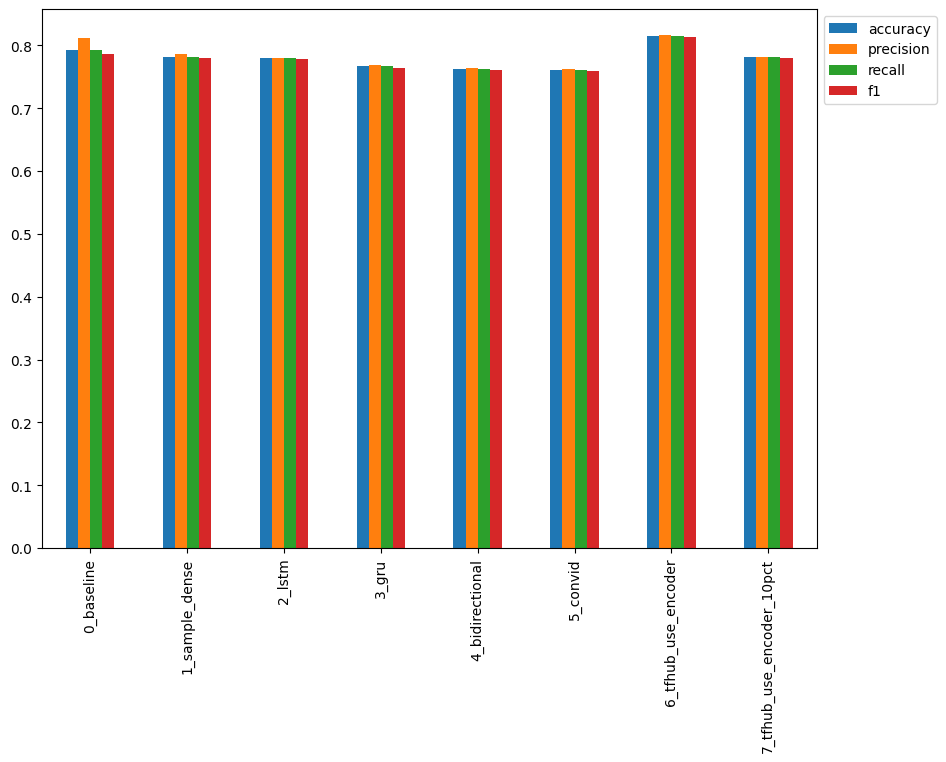

In [94]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

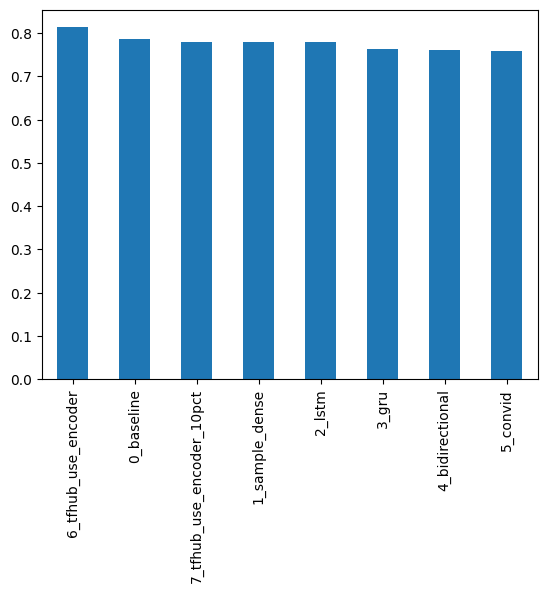

In [95]:
from matplotlib.pyplot import xlabel
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind='bar')

## Further training and improvement

## Upload to TensorBoard

- ```!tensorboard dev upload --logdir ./model_logs/ --name "" --description "" --oneshot```
- `!tensorboard dev list`

> **Resources** TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, checkout [Weights&Biases](https://wandb.ai/site).

In [96]:
!pip install -U tensorboard
!tensorboard --version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires tensorboard<2.14,>=2.13, but you have tensorboard 2.14.0 which is incompatible.


2023-09-16 20:20:19.297532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2.14.0


In [105]:
!tensorboard dev upload --logdir ./model_logs/ --name "Experiments_on_NLP_problem" --description "" --one_shot

2023-09-16 20:23:50.184619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/PAQVQB3xSO6zcvZrIR4bKw/

[2023-09-16T20:23:57] Started scanning logdir.
[2023-09-16T20:24:05] Total uploaded: 240 scalars, 0 tensors, 8 binary objects (3.0 MB)
[2023-09-16T20:24:05] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/PAQVQB3xSO6zcvZrIR4bKw/


In [107]:
!tensorboard dev list

2023-09-16 20:24:28.026146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/PAQVQB3xSO6zcvZrIR4bKw/
	Name                 Experiments_on_NLP_problem
	Description          [No Description]
	Id                   PAQVQB3xSO6zcvZrIR4bKw
	Created              2023-09-16 20:23:57 (33 seconds ago)
	Updated              2023-09-16 20:24:05 (25 seconds ago)
	Runs                 16
	Tags                 5
	Scalars              240
	Tensor bytes         0
	Binary object bytes  3153922
https://tensorboard.dev/experiment/kIo72WbGQ5ODUwnjBZW0Kw/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   kIo72WbGQ5ODUwnjBZW0Kw
	Created              2023-08-19 23:06:17
	Updated              2023-08-19 23:06:24
	Runs                 8
	Tags                 5
	Scalars            

## Save and Load the Best Model

There are two main formats to save a model to in TensorFlow:
- The HDF5
- The `SavedModel` (default in TensorFlow)

In [99]:
model_6_results

{'accuracy': 0.8149606299212598,
 'precision': 0.8166816944448522,
 'recall': 0.8149606299212598,
 'f1': 0.8136303789632117}

In [100]:
# Save model_6 as it is the currently best model
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [101]:
# Load model with custom Hub Layer (required for HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [102]:
# How does our loaded model perform
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4254 - accuracy: 0.8150


[0.4254266917705536, 0.8149606585502625]

In [103]:
# SavedModel format - create a folder
model_6.save("model_6_SavedModel")

In [104]:
# In this format, you don't have to custom layer
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel")

In [106]:
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4254 - accuracy: 0.8150


[0.4254266917705536, 0.8149606585502625]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong?



In [108]:
# Download a pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-09-16 20:24:41--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.207, 172.217.193.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  32.6MB/s    in 17s     

2023-09-16 20:24:59 (54.1 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.i

In [109]:
# Import previously trained model
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [111]:
# Make prediction with the loaded model
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained.predict(val_sentences)))
model_6_pretrained_preds[:10]

24/24 [==============================] - 1s 20ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [113]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "prob": tf.squeeze(model_6_pretrained.predict(val_sentences))})
val_df

24/24 [==============================] - 1s 22ms/step


,text,target,pred,prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.137074
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.095865
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
760,Crack in the path where I wiped out this morni...,0,1.0,0.612631


In [114]:
# Find the wrong predictions and sort by the diff
most_wrong = val_df[val_df["target"]!=val_df["pred"]].sort_values("prob")
most_wrong

,text,target,pred,prob
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
233,I get to smoke my shit in peace,1,0.0,0.042087
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
...,...,...,...,...
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982


* False positive - should be 0 (not disaster) but predicted as 1 (disaster).
* False negative - should be 1 but predicted as 0.

### Visualize the false positive

In [117]:
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {pred}, Prob:{prob}")
  print(f"Text:\n {text}")
  print("--------\n")

Target: 0, Pred: 1.0, Prob:0.7666250467300415
Text:
 Air Group is here to the rescue! We have 24/7 Emergency Service! Learn more about it here - http://t.co/9lyx7zMtHE http://t.co/5PbC96rTMJ
--------

Target: 0, Pred: 1.0, Prob:0.7669006586074829
Text:
 @freefromwolves GodsLove &amp; #thankU brother Danny for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake &amp; Tsunami
--------

Target: 0, Pred: 1.0, Prob:0.80312180519104
Text:
 @madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods
--------

Target: 0, Pred: 1.0, Prob:0.8108397126197815
Text:
 [55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY
--------

Target: 0, Pred: 1.0, Prob:0.814815878868103
Text:
 @SonofLiberty357 all illuminated by the brightly burning buildings all around the town!
--------

Target: 0, Pred: 1.0, Prob:0.8272131681442261
Text:
 @AshGhebran

In [118]:
for row in most_wrong[:10].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {pred}, Prob:{prob}")
  print(f"Text:\n {text}")
  print("--------\n")

Target: 1, Pred: 0.0, Prob:0.03718578442931175
Text:
 Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube
--------

Target: 1, Pred: 0.0, Prob:0.03894944489002228
Text:
 Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP
--------

Target: 1, Pred: 0.0, Prob:0.038997940719127655
Text:
 Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy
--------

Target: 1, Pred: 0.0, Prob:0.042086850851774216
Text:
 I get to smoke my shit in peace
--------

Target: 1, Pred: 0.0, Prob:0.04391849413514137
Text:
 @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren
--------

Target: 1, Pred: 0.0, Prob:0.04963730648159981
Text:
 You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.
--------

Target: 1, Pred: 0.0, Prob:0.0545970126

The point here is that we scan through these most wrong prediction and see if it is the model's wrong or the original labels' faults.

In [120]:
val_sentences.shape, test_df.shape

((762,), (3263, 4))

## Test our model on Test Dataset

In [121]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [128]:
test_sentences = test_df["text"].to_numpy()
test_sentences[:10]

array(['Just happened a terrible car crash',
       'Heard about #earthquake is different cities, stay safe everyone.',
       'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
       'Apocalypse lighting. #Spokane #wildfires',
       'Typhoon Soudelor kills 28 in China and Taiwan',
       "We're shaking...It's an earthquake",
       "They'd probably still show more life than Arsenal did yesterday, eh? EH?",
       'Hey! How are you?', 'What a nice hat?', 'Fuck off!'], dtype=object)

In [129]:
test_probs = model_6_pretrained.predict(test_sentences)
test_preds = tf.squeeze(tf.round(test_probs))
test_preds[:10]

102/102 [==============================] - 2s 18ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [134]:
# Visualize the test results
test_df = pd.DataFrame({"text": test_sentences,
                        "pred_label": test_preds,
                        "prob": tf.squeeze(test_probs)})
test_df.sort_values("pred_label")

,text,pred_label,prob
1631,You were just waiting for us to go down in flames,0.0,0.175947
1579,Even with delays? Like a bogged down cpu? #gun...,0.0,0.325517
1578,I just got electrocuted by my #HP Chromebook c...,0.0,0.366090
1577,AMAZON KINDLE FIRE 7' FAST REPAIR SERVICE FOR ...,0.0,0.164578
1576,almost set the house on fire tryna make fuckin...,0.0,0.095271
...,...,...,...
1610,Volunteers served first responders today durin...,1.0,0.887887
1608,'An alarming trend among first responders is r...,1.0,0.847963
1607,Good Day Columbia: First Responders Memorial w...,1.0,0.715855
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,1.0,0.517644


In [138]:
# Check random 10 tweets labels as 1 (disaster)
disaster_tweets = test_df[test_df["pred_label"]==1].sample(frac=0.01)
for row in disaster_tweets[:10].itertuples():
  _, text, pred_label, prob = row
  print(f"Target: {pred_label}, Prob:{prob}")
  print(f"Text:\n {text}")
  print("--------\n")

Target: 1.0, Prob:0.7726750373840332
Text:
 The Murderous Story Of AmericaÛªs First Hijacking http://t.co/VgBOpxb6Wg
--------

Target: 1.0, Prob:0.7881110310554504
Text:
 Check out more data on Upper Wabash reservoirs here on @LouisvilleUSACE site: http://t.co/hqqLQUqZmD
--------

Target: 1.0, Prob:0.9450300931930542
Text:
 #Amtrak Rail #Disaster http://t.co/H6Ol73KZJg http://t.co/Qfydu4PVGK
--------

Target: 1.0, Prob:0.6721906065940857
Text:
 #FedEx no longer to transport #bioterror germs in wake of #anthrax lab mishaps http://t.co/Ziw1RWPJkK
--------

Target: 1.0, Prob:0.9085261821746826
Text:
 The day of death destruction chaos; 60000 to 80000 people were killed instantly. Please take sometime to remember and think about others
--------

Target: 1.0, Prob:0.9963710308074951
Text:
 #DNR
Res. buildings shelled &amp; on fire in #Gorlovka tonight.
Civilian casualties Jan-July 2015:ÛÓ
164 killed (incl. 16 children)
501 wounded
--------

Target: 1.0, Prob:0.8767529726028442
Text:
 Refu

In [140]:
# Check random 10 tweets labels as 0 (not disaster)
not_disaster_tweets = test_df[test_df["pred_label"]==0].sample(frac=0.01)
for row in not_disaster_tweets[:10].itertuples():
  _, text, pred_label, prob = row
  print(f"Target: {pred_label}, Prob:{prob}")
  print(f"Text:\n {text}")
  print("--------\n")

Target: 0.0, Prob:0.4764389395713806
Text:
 LIVE on #Periscope: Wild Wing Epicentre https://t.co/U2fUK072F9
--------

Target: 0.0, Prob:0.41196954250335693
Text:
 @mickbland27 It is disturbing! Emergency services &amp; first responders should work together not slander try &amp; get each other killed.
--------

Target: 0.0, Prob:0.2268470972776413
Text:
 @James_May_Not @aMusicVideoaDay @knelligan12 @king_ruckus There's a lot of businesses that operate on outskirts &amp; I never feel in danger
--------

Target: 0.0, Prob:0.22704775631427765
Text:
 Once I get my stomach together I will be wearing crop tops during all seasons. Rain or shine. Snow sleet or hail.
--------

Target: 0.0, Prob:0.015199629589915276
Text:
 I would love to #win Suze's amazing filled #beauty #bag #giveaway! Contents from L'Occitane Body Shop &amp; Lavera. http://t.co/hEjJVVRsTY
--------

Target: 0.0, Prob:0.22697018086910248
Text:
 new name: mudslide
--------

Target: 0.0, Prob:0.1474403738975525
Text:
 This Davies

## Predict on tweets from wild - is that tweets a disaster or not disaster.

1. [Lex Fridman](https://twitter.com/lexfridman/status/1703075468243562869)

> Do good things for others, for no reason at all. It makes life more fun.   
Transactional relationships are meh.

2.[An armed alert](https://twitter.com/UNC/status/1702017917057941964)

> !Alert Carolina! Emergency - Update: Reports of an armed & dangerous person. Continue to shelter, silence your phones, and check http://alertcarolina.unc.edu for information.

In [149]:
# Create a function to predict any sample with our model
def predict_any(model, sample):
  probs = model.predict(sample)
  disaster = tf.squeeze(tf.round(probs))
  if disaster:
    print("This tweet is a disaster!")
  else:
    print("Not a disaster.")


In [151]:
sample = ["Do good things for others, for no reason at all. It makes life more fun. Transactional relationships are meh."]
predict_any(model_6_pretrained, sample)

1/1 [==============================] - 0s 95ms/step
Not a disaster.


In [152]:
sample = ["!Alert Carolina! Emergency - Update: Reports of an armed & dangerous person. Continue to shelter, silence your phones, and check http://alertcarolina.unc.edu for information."]
predict_any(model_6_pretrained, sample)

1/1 [==============================] - 0s 69ms/step
This tweet is a disaster!


## The spped/score tradeoff


In [143]:
# make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time-start_time # calculate how long predictions took
  time_pre_pred = total_time/len(samples)
  return total_time, time_pre_pred

In [145]:
# Calculate model 6 time per pred
model_6_total_pre_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                           samples=val_sentences)

model_6_total_pre_time, model_6_time_per_pred

24/24 [==============================] - 0s 18ms/step


(0.6000690310002028, 0.0007874921666669328)

In [147]:
# Calculate baseline time per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.027760432999457407, 3.643101443498347e-05)

Text(0, 0.5, 'F1-score')

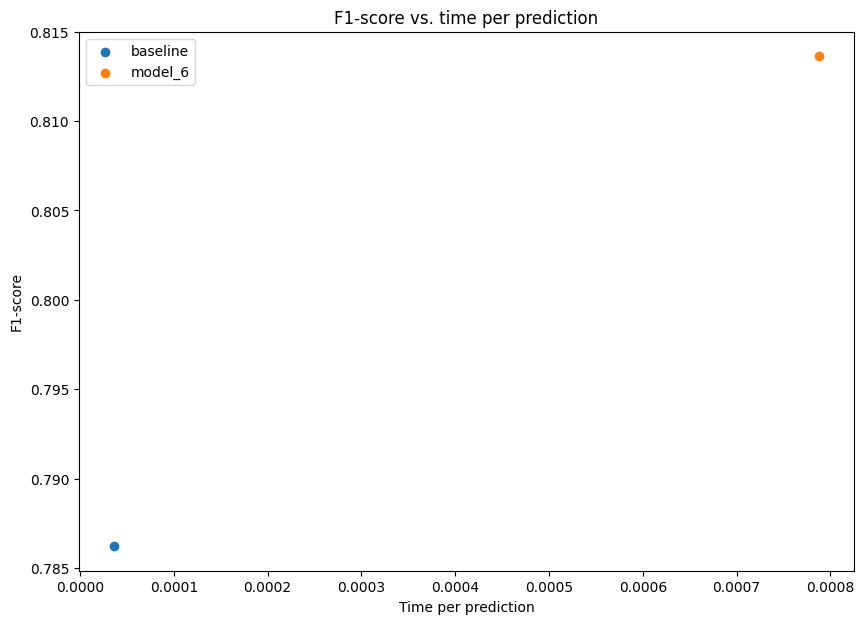

In [148]:
# Visualize the relationship between time_per_pred and f1-score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="model_6")
plt.legend()
plt.title("F1-score vs. time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")

> The ideal position for this plot should be on the upper left, where time per prediction is small and f1-score is high.

Therefore, sometimes we need to tradeoff on speed and score. In this case, does it worth 10x more time for the increase of f1-score?